In [1]:
from data_loader import DataLoader
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import sys
from ml_util import *

dl = DataLoader('../data/')
x_train, x_valid, x_test, y_train, y_valid, y_test = dl.GetTrainValidTest()

In [3]:
# lstm model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import activations
import tensorflow as tf

def focal_loss(pred, real,gamma=2):
    L=-real*((1-pred)**gamma)*tf.log(pred+1e-15)
    L=tf.reduce_sum(L,axis=1)
    return L

batch_size = 512
seq_length = 32
def lstm_model():
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_dim = dl.x.shape[1])),#, return_sequences=True))
    #model.add(layers.Flatten())
    #model.add(layers.LSTM(50, input_shape=(seq_length, x.shape[1]),return_sequences=False))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(2, name='out'))
    model.add(layers.Activation('sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
        #optimizer=keras.optimizers.SGD(1e-2),
        loss=keras.losses.CategoricalCrossentropy(),
        #loss = focal_loss,
        metrics=['accuracy'])
    return model

model = lstm_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                6100      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
out (Dense)                  (None, 2)                 42        
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 8,292
Trainable params: 8,292
Non-trainable params: 0
_________________________________________________________________


In [7]:
# filter data: remove those nan and inf
def Filter(x_, y_):
    nan_cond = (~np.isnan(y_)) & (np.isnan(x_).sum(axis=1) == 0)
    inf_cond = (~np.isinf(y_)) & (np.isinf(x_).sum(axis=1) == 0)
    return x_[nan_cond & inf_cond], y_[nan_cond * inf_cond]
    #print(x.shape, y_shape, rx.shape, ry.shape)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(np.reshape(dl.y>0, (-1,1)))

from tensorflow.keras.callbacks import EarlyStopping
earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=4)


xt ,yt = Filter(x_train, y_train)
xv, yv = Filter(x_valid, y_valid)
yt, yv = ohe.transform(np.reshape(yt>0, (-1, 1))), ohe.transform(np.reshape(yv>0, (-1, 1)))
model.fit(xt, yt, validation_data=[xv, yv], callbacks=[earlystop_callback], epochs=30, batch_size=1024)

    

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


Train on 75415 samples, validate on 18850 samples
Epoch 1/30
75415/75415 [==============================] - 1s 8us/sample - loss: 0.5589 - acc: 0.7092 - val_loss: 0.5702 - val_acc: 0.7003
Epoch 2/30
75415/75415 [==============================] - 1s 8us/sample - loss: 0.5586 - acc: 0.7095 - val_loss: 0.5701 - val_acc: 0.7003
Epoch 3/30
75415/75415 [==============================] - 1s 9us/sample - loss: 0.5585 - acc: 0.7094 - val_loss: 0.5701 - val_acc: 0.6998
Epoch 4/30
75415/75415 [==============================] - 0s 6us/sample - loss: 0.5584 - acc: 0.7094 - val_loss: 0.5701 - val_acc: 0.6998
Epoch 5/30
75415/75415 [==============================] - 1s 9us/sample - loss: 0.5584 - acc: 0.7095 - val_loss: 0.5701 - val_acc: 0.7002
Epoch 6/30
75415/75415 [==============================] - 1s 9us/sample - loss: 0.5583 - acc: 0.7097 - val_loss: 0.5701 - val_acc: 0.6999


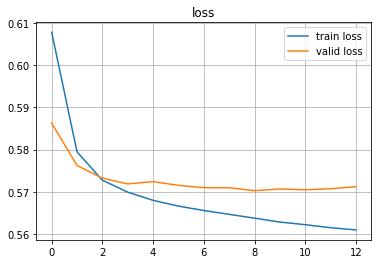

In [5]:
h = model.history.history
train_loss, valid_loss  = h['loss'], h['val_loss']
plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
plt.title('loss')
plt.legend()
plt.grid()
plt.show()

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Confusion matrix, without normalization


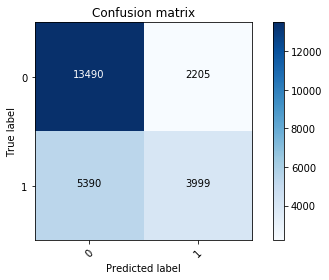

              precision    recall  f1-score   support

      class0       0.71      0.86      0.78     15695
      class1       0.64      0.43      0.51      9389

   micro avg       0.70      0.70      0.70     25084
   macro avg       0.68      0.64      0.65     25084
weighted avg       0.69      0.70      0.68     25084



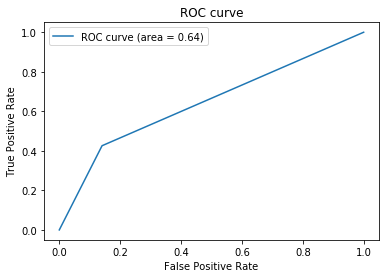

In [6]:
from ml_util import *
pred = model.predict(x_test)
(pred.argmax(axis=1) == 0).mean()
a = ClsReport(model, y_test > 0, pred.argmax(axis=1), binary=True)